<img src="./img/HWNI_logo.svg"/>

# Lab 12 - Clustering

In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import sklearn as sk

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

#import util.lab11utils as utils

from ipywidgets import interact,interactive, fixed, interact_manual

import util.plotFunctions as pf
import util.util as util

data1d = np.load('./data/data1d.npz')['data'] #problem 1

data2d = np.load('./data/data2d.npz') #problems 2 and 3
mixtures = [data2d['mog'],data2d['X'],data2d['O'],]

#utils.formatDataframes()

In [2]:
import numpy as np

def pullCluster(dataset,idx):
    indices = np.equal(dataset[:,2],idx)
    clusterData = dataset[indices,:-1]
    return clusterData

def runEM(dataset,oldParameters,updateSigma=True,updateW=True):
    #inference step - Bayes' Rule
    posteriors = inferHiddenStates(dataset,oldParameters)
    #maximization step - weighted version of observed method
    newParameters = updateParameters(dataset,posteriors,oldParameters,
                                     updateSigma=updateSigma,
                                     updateW=updateW)
    return posteriors,newParameters

def inferHiddenStates(dataset,parameters):
    #use the parameters to compute the posterior of alpha for each datapoint
    posteriors = []
    for idx in range(len(dataset)):
        datapoint = dataset[idx]
        posteriors.append(computePosterior(datapoint,parameters))
        
    return np.asarray(posteriors)

def updateParameters(dataset,posteriors,oldParameters,updateSigma=True,updateW=True):
    #update (some of) the parameters using the "weighted average" rule
    
    newParameters = oldParameters #just copying the structure
    numElements = len(newParameters['w']) #how many mixture Elements?
    d = len(newParameters['mu'][0]) #how many dimensions?
    numDatapoints = len(dataset) #how many datapoints
   
    mu = [np.zeros(d)]*numElements #initialize a list of numElements vectors, each with dimension d
    sigma = [np.zeros((d,d))]*numElements #same as above, but for a list of covariances
    w = [0]*numElements #and a list of scalars

    for alpha in range(numElements):
        
        totalPosteriorAlpha = sum([posterior[alpha] for posterior in posteriors])
        
        mu[alpha] = posteriorWeightedAverage(dataset,posteriors[:,alpha])
        
        empiricalCovariances = calculateCovariances(dataset,mu[alpha])
        
        if updateSigma == True:
            sigma[alpha] = posteriorWeightedAverage(empiricalCovariances,posteriors[:,alpha])
            newParameters['sigma'] = sigma

        if updateW == True:
            w[alpha] = totalPosteriorAlpha/numDatapoints
            newParameters['w'] = w
    
    newParameters['mu'] = mu
    
    return newParameters

def calculateCovariances(dataset,mu):
    numElements = len(dataset)
    diffs = [np.atleast_2d(x-mu) for x in dataset]
    return [ np.dot(diff.T, diff) * 2**-1
            for diff in diffs]

def computePosterior(x,parameters):
    mu = parameters['mu'] #list of means
    sigma = parameters['sigma'] #list of cov matrices
    w = parameters['w'] # list of p(alpha)s
    
    numElements = len(w)
    
    unNormalizedPosteriors = [] #list containing top half of Bayes rule fraction
    for alpha in range(numElements):
        prior = w[alpha] #p(alpha)
        likelihood = multivariateGaussPDF(x,mu[alpha],sigma[alpha]) #p(x|alpha)
        unNormalizedPosterior = prior*likelihood #top half of fraction from Bayes rule
        unNormalizedPosteriors.append(unNormalizedPosterior)
        
    dataMarginal = sum(unNormalizedPosteriors) #bottom half of fraction from Bayes rule
    
    #we want a posterior distribution - p(alpha|x) - so we end up with a list of length numElements
    posterior = [unNormalizedPosterior/dataMarginal for unNormalizedPosterior in unNormalizedPosteriors]
    
    return posterior

def multivariateGaussPDF(x,mu,sigma):
    lamda = np.linalg.inv(sigma) #alternative name for sigma inverse
    d = len(mu)
    Z = np.sqrt(2*np.pi)**(d/2) * np.sqrt(np.linalg.det(sigma))
    diff = x-mu
    p = Z**-1 * np.exp(-0.5 * np.dot(np.dot(diff.T,lamda), diff))
    return p

def posteriorWeightedAverage(values,posterior):
    count = len(posterior) 
    return sum([values[idx]*posterior[idx] for idx in range(count)])/sum(posterior)


def makeParams(K=2,muSpread=2,sigmaWidth=1):
    #muSpread -- how big of a square should I draw the means from?
    #sigmaWidth -- how big should the variances be?
    
    mu = [np.random.uniform(low=-muSpread,high=muSpread,size=2) for _ in range(K)]
    sigma = []
    for _ in range(K+1):
        # initially commented: code to generate random covariance matrix
        #randMat = np.random.uniform(size=(2,2))
        #randPSD = randMat @ randMat.T
        
        sigma.append(sigmaWidth*np.eye(2)) #code to just pick a scaled identity matrix
    w = [1/K]*K
    return {'mu': mu, 'sigma':sigma,'w':w}


In [3]:
import matplotlib.pyplot as plt
#import matplotlib.mlab as mlab
from matplotlib.patches import Ellipse
import numpy as np
from util.util import pullCluster
colorList = ['red','darkcyan','brown','hotpink','plum','darkolivegreen',
             'skyblue','mediumspringgreen','indigo']

def plotData(data, title):
    fig, axis = plt.subplots(1)
    axis.plot(data[0,:], data[1,:], '.',  c='gray', alpha=0.2, markersize=10)
    fig.suptitle(title)
    fig.show()

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def plotLikelihood(data, logLikelihoods, means, sigma, numGauss, title):
    data_mean = np.mean(data) # MLE is the mean of the data
    z = (2*np.pi*sigma**2)**(1/2)
    bestGauss = 1/z * np.exp(-(data-data_mean)**2/(2*sigma**2))
    logLikelihoodGauss = np.mean(np.log(bestGauss))
    fig, ax = plt.subplots(2,figsize=(12,6))
    ax[0].plot(data_mean, logLikelihoodGauss, "*", color="k",
    markersize=10)
    ax[0].plot(means, logLikelihoods, "r")
    ax[0].set_ylabel("Log Likelihood", fontsize=12)
    ax[1].hist(data, normed=True,histtype='stepfilled',alpha=0.2,color='gray',bins=20)
    ymin,ymax = ax[0].get_ylim()
    xmin,xmax = ax[0].get_xlim()
    ax[0].vlines(0,ymin,ymax,linewidth=2,linestyle='dashed')
    gaussData = np.linspace(np.min(data)-10, np.max(data)+10, 100)
    step = int(len(means)/numGauss)
    gaussIdxList = np.arange(0, len(means), step)
    ax[1].set_title(
        str(len(gaussIdxList))+" Example Gaussians and Data Distribution",
        fontsize=12)
    for gaussIdx in gaussIdxList:
        z = (2*np.pi*sigma**2)**(1/2)
        gaussian = (1/z *
            np.exp(-(gaussData-means[int(np.floor(gaussIdx))])**2 / (2 * sigma**2)))
        ax[1].plot(gaussData, gaussian,linewidth=2)
  #ax[1].set_xlim(np.min(data), np.max(data))
    ax[1].set_xlim(xmin,xmax)
    fig.suptitle(title, fontsize=14)
    return fig

def plotContour(mu,sigma,ax,color='blue',numContours=3):
    eigvalues,eigvectors = np.linalg.eig(sigma)
    primaryEigvector = eigvectors[:,0]
    angle = computeRotation(primaryEigvector)
    isoProbContours = [Ellipse(mu,
                               l*np.sqrt(eigvalues[0]),
                               l*np.sqrt(eigvalues[1]),
                               alpha=0.3/l,color=color,
                              angle=angle) 
                       for l in range(1,numContours+1)]
    [plt.gca().add_patch(isoProbContour) for isoProbContour in isoProbContours]
    
def computeRotation(vector):
    return (180/np.pi)*np.arctan2(vector[1],vector[0])
    
def dataScatter(data,color='grey'):
    plt.scatter(data[:,0],data[:,1],color=color,edgecolor=None,alpha=0.1)
    return

def plotObservedMix(dataset,means,sigmas,contours=True):
    plt.figure(figsize=(4,4))
    #colorList = ['darkcyan','hotpink','plum']
    minIdx = int(np.min(dataset[:,2]))
    maxIdx = int(np.max(dataset[:,2]))
    mixtureElements = [pullCluster(dataset,idx) for idx in range(minIdx,maxIdx+1)]
    for idx,element in enumerate(mixtureElements):
        colorIdx = idx % len(colorList)
        if not contours:
            dataScatter(element,color=colorList[colorIdx])
        if contours:
            dataScatter(element)
            plotContour(means[idx],sigmas[idx],plt.gca(),color=colorList[colorIdx])
    return

def plotUnobservedMix(dataset):
    plt.figure(figsize=(4,4))
    minIdx = int(np.min(dataset[:,2]))
    maxIdx = int(np.max(dataset[:,2]))
    mixtureElements = [pullCluster(dataset,idx) for idx in range(minIdx,maxIdx+1)]
    for idx,element in enumerate(mixtureElements):
        dataScatter(element)
    return

def plotEMResults(dataset,K,parameters):
    plt.figure()
    dataScatter(dataset)
    for idx in range(K):
        mu = parameters['mu'][idx]; sigma = parameters['sigma'][idx]
        coloridx = idx % (len(colorList))
        plotContour(mu,sigma,plt.gca(),color=colorList[coloridx],numContours=5)

In [86]:
def setupKMeans(K):
    parameters = makeParams(K, #how many components?
                             
                             #means are drawn uniformly from a square centered at 0
                             muSpread=2, #how big should that square be?
                             
                             #covariance matrices are scaled identity matrix
                             sigmaWidth=0.01 #what should that scaling factor be?
                                 # make it small to approximate K-Means
                            )
    
    updateSigma = False
    updateW = False
    return parameters,updateSigma,updateW

## Introduction

In the datasets we've modeled so far, we've been given paired inputs and outputs -- continuous outputs in regression models, discrete outputs in classification models. Our goal has been to learn to model the relationship between those inputs and outputs. We begin in a state of ignorance: we presume that inputs are being transformed into outputs, but we have no idea what kind of transformation is happening. Metaphorically, we represent our state of ignorance by drawing the inputs passing through a "black box" on the way to becoming ouputs.

In this kind of modeling, we often aim to "open the black box" -- to peer inside and determine just exactly how the inputs are being transformed. To approach this modeling problem statistically is to give up on physically opening the box. Instead, we aim to design our own box, hopefully transparent, in such a way that the outputs generated by the box we design and, hopefully, understand are indistinguishable from the outputs of the original, opaque box.

![Supervised Models](./img/supervised.png)

But the data we wish to model isn't always a simple input-output relationship. Sometimes, we have a collection of observations that we'd like to be able to *describe simply*. We'd like to be able to extract the structure of this data -- to break multidimensional data down into a number of straightforwardly-interacting lower dimensional components.

To use our black box metaphor, we need to rethink the location of our data in our picture. Instead of sitting astride the black box, our data now comes out of the black box. Our goal in statistical modeling is to again design our own, hopefully less opaque, box, which we can then use to generate data that looks as much like the data we actually observed as possible.

![One View of Unsupervised Models](./img/unsupervised-1.png)

Notice that the inputs to this model are unobserved.

In this way of thinking, the problem we're solving is called a *hidden variable problem*. There's another way of adapting the black box metaphor to our new problem, drawn below:

![Another View of Unsupervised Models](./img/unsupervised-2.png)

Here, instead of viewing the data as the output of a black box whose inputs we don't know, we instead view the data as the input to a model whose outputs we don't know. Thus, when our model makes a guess as to what the output for the current input should be, there's not a directly provided "correct" output for it to compare against. The model must learn without "supervision" in the form of being told the correct answers. For this reason, these models are called *unsupervised* models, and fitting them to data called *unsupervised learning*. The models we've considered up to this point were *supervised* models.

It should come as no surprise (especially to anyone who has attended graduate school) that unsupervised learning is harder than supervised learning.

In fact, we can connect the first way we wrote down the problem, using hidden variables, to one of the main problems that an organism's brain has to solve, perception. Let's relabel the components of our visualization:

![Perception as a Hidden Variable Problem](./img/perception-as-inference.png)

In this view, the organism has access only to sensory data: air pressure waveforms from the ears, patterns of light from the eyes, and so on. But what the organism actually cares about are the causes of that sensory data: predators, prey, objects in the world. These causes give rise to the sensory data through processes in the world, mainly physical processes like the reflection, scattering, and refraction of light or sound waves, the binding and unbinding of chemicals in the olfactory system, and so on.

Figuring out an algorithm to solve perception is clearly an unsolved problem - some might say unsolvable - so we'll stick to a simpler case, where more progess has been made. 

## Clustering

Clustering is the unsupervised counterpart to classification. Recall that in a classification model, we try to map continuous inputs to discrete outputs. The inputs and outputs are paired for us.

Say we collected some labeled data to train a classifier. We might plot it like so, using color to indicate label:

In [ ]:
plotObservedMix(mixtures[0],[],[],contours=False);

Imagine that we come back to our computer to find that we accidentally deleted the label file. If we plotted the data, it might look like this:

In [ ]:
plotUnobservedMix(mixtures[0]);

We'd like to be able to "re-label" this data. A human wouldn't have too much trouble, even if they'd never seen the original data -- it'd just take awhile, as they painstakingly relabeled the data, point by point. We'd like to find an algorithm to perform this labeling for us. We'd also like it to extend to cases where the number of dimensions is too large for a human to visualize, and to cases where the answers aren't so clear, like the one below:

In [ ]:
plotUnobservedMix(mixtures[1])

For the purposes of this lab, we'll focus on clustering problems where the individual clusters are shaped like a Gaussian distribution: round or ellipsoid. We do this because the general problem of clustering, where the clusters might have any shape, is (mostly) unsolved. For an example, see below:

In [ ]:
plotUnobservedMix(mixtures[2])

### Breaking Down the Problem of Clustering

First, let's look at our clustering problem using a black box diagram.

![Clustering](./img/clustering.png)

As written, this isn't a problem we know how to solve. But what if we knew which data points came from which clusters? Then our problem would look like the following:

![If clusters were known](./img/known-cluster.png)

This looks just like a supervised problem! And to be sure, if we only had those pesky cluster labels, we could use our supervised learning techniques to figure out what each cluster looked like. We'd posit a family of models, pick some random starting parameters, and then perform gradient descent on the likelihood function  to find the likeliest model.

But we don't have the cluster labels. Let's consider what the problem would look like if we knew the structure of the clusters -- if we had a model that related cluster labels to possible data values:

![If We Knew the Cluster Structure](./img/known-structure.png)

This is also a solvable problem. We can use the laws of probability, namely [Bayes' Rule](http://charlesfrye.github.io/stats/2016/02/04/bayes-rule.html), to figure out what the cluster labels are likely to be. In this form, we have essentially the same problem as we have when we have a known classification model and we've observed some unlabeled data points (the arrows are just reversed).

But we don't know the correct model -- we don't know what the clusters look like -- and we don't know the correct labels -- otherwise we'd be going supervised learning. So what do we do?

### Solving Clustering By Making Stuff Up

We simply make something up. We pick a set of model parameters at random and treat them *as though they were the true model*. That means we're looking at the third of the three diagrams in the section above. Then, even though we know the model is wrong, we use it to assign labels to the datapoints.

But we don't stop there. Instead, we use these newfound labels to *update the model according to maximum likelihood*. Importantly, just because a set of labels were the most probable labels under a given model doesn't mean that another model wouldn't assign an even higher likelihood to those points.

We iterate this procedure, updating the model and re-assigning the labels, until the parameters and the labels stop changing.

### Simple(ish) Example: K-Means Clustering

As a first pass, we adopt a heuristic. We want to fit the centers of clusters only. We plop down $K$ means in the data space, then assign each data point to a cluster based on which mean is closest. Then we set the value of each cluster mean to the mean of the points that were assigned to it. Lather, rinse, repeat.

Cells below will run K-means$^\dagger$. First one sets the algorithm up, second one runs it `numIters` times. K-means can be unstable, so sometimes it will throw errors. Just restart from a new initialization. Hack: set `numIters` to 0 to see the initial state.

$\dagger$ Technically, an approximation to K-means, not exactly the same algorithm. The behavior is similar.

In [84]:
# run this block once per fit to set parameters

#which dataset?
mixtureIdx = 1
dataset = mixtures[mixtureIdx][:,:-1]

K = 3 #how many components?

parameters,updateSigma,updateW = setupKMeans(K)

# run this block to fit the model -- can be run multiple times per fit

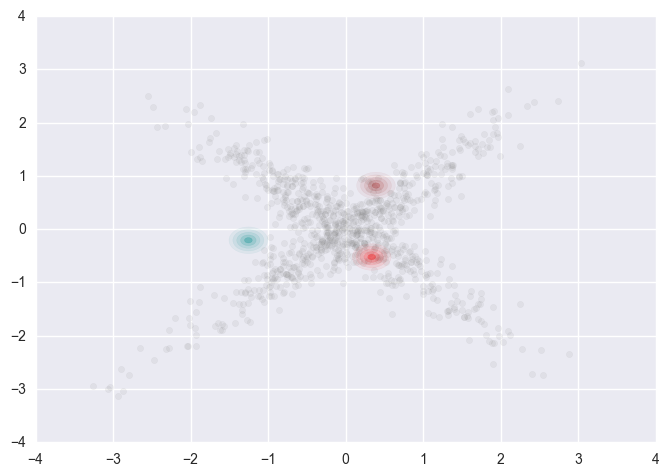

In [85]:
#how many times do we run the updates each time we run the cell?
# set to 1 and run this block repeatedly 
# if you want to watch the fit step-by-step
numIters = 1

for _ in range(numIters):
    posteriors,newParameters = util.runEM(dataset,parameters,
                                          updateSigma,
                                          updateW)

pf.plotEMResults(dataset,K,parameters)

Start with the first dataset, which clearly has 4 clusters. Mess around and see if you always get the "right" answer. Also, do the colors end up in the same spot each time?

Try changing K to values other than 4. What happens?

Check out the other datasets. Does K-means work here?

### Less Simple Example: Gaussian Mixture Clustering

If we try a bit harder, we can get a better algorithm. First, we fit both the means and the covariances of the Gaussians -- the covariance of a cluster is determined by the covariance of the points in the cluster, just like the mean. Second, we keep track of how likely datapoints are to come from each cluster and use that to do *weighted averages*. K-means is kind of like a weighted average where all the weights are 1 and 0.

In [141]:
# run this block once per fit to set parameters

#which dataset?
mixtureIdx = 1
dataset = mixtures[mixtureIdx][:,:-1]

K = 2 #how many components?

parameters = makeParams(K, #how many components?
                             
                             #means are drawn uniformly from a square centered at 0
                             muSpread=0.01, #how big should that square be?
                             
                             #covariance matrices are scaled identity matrix
                             sigmaWidth=0.1 #what should that scaling factor be?
                                 # make it small to approximate K-Means
                            )
    
updateSigma = True
updateW = True

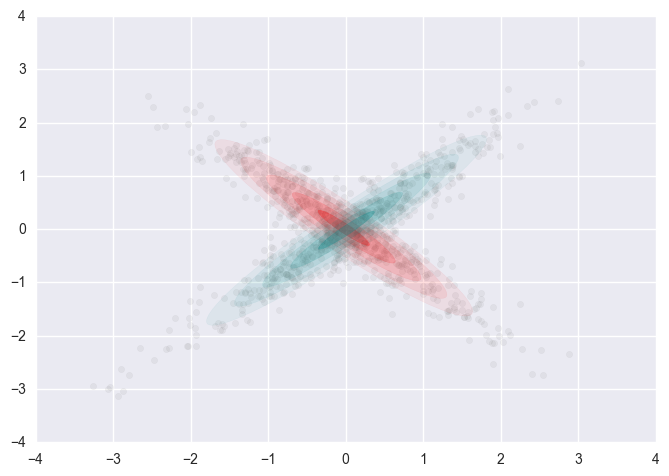

In [142]:
#how many times do we run the updates each time we run the cell?
# set to 1 and run this block repeatedly 
# if you want to watch the fit step-by-step
numIters = 10

for _ in range(numIters):
    posteriors,newParameters = util.runEM(dataset,parameters,
                                          updateSigma,
                                          updateW)

pf.plotEMResults(dataset,K,parameters)

Does this fix all of our problems? Does it fix any of our problems?

Try the mixture at index 1, the "X", many times, with `K=2`. Does it ever work? Try `K=4`. Do we find reasonable models? **Hint**: change `muSpread` to a small value. Why is it a bad thing that the chances of success depend on a hyperparameter?

Try `K=100` on the mixture at index 2, the "bull's eye". Are we recovering the structure of the data? What are we doing?

### Caveats

Issues should be obvious from trying the method on the data above: very prone to local minima, sensitive to hyperparameters, difficult to identify the "true" model, even when we get a good likelihood value.

Good news: the method of making stuff up and then alternating updating labels and updating parameters can actually *work* to solve the general problem, not just clustering. Unfortunately, it takes a very long time to run on complicated datasets, like the high definition images our eyes collect. Somebody should make it faster...